# 过拟合与正则化 (With ``gluon``) 

## 导入库函数

In [1]:
import mxnet as mx
import numpy as np
import matplotlib as mlt

from mxnet import nd
from mxnet import autograd
from mxnet import gluon
import matplotlib.pyplot as plt

## 加载数据集

In [2]:
mnist = mx.test_utils.get_mnist()
num_examples = 1000
batch_size = 64
train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(mnist['train_data'][:num_examples].astype(np.float32)
                ,mnist['train_label'][:num_examples].astype(np.float32)), batch_size=batch_size, shuffle=True)
test_data = gluon.data.DataLoader(gluon.data.ArrayDataset(mnist['test_data'][:num_examples].astype(np.float32)
                ,mnist['test_label'][:num_examples].astype(np.float32)), batch_size=batch_size, shuffle=False)

In [3]:
# test
for data, label in test_data:
    print(data.shape)
    print(label.shape)
    break

(64, 1, 28, 28)
(64,)


## 定义模型

In [4]:
net = gluon.nn.Sequential()
with net.name_scope():
    net.add(gluon.nn.Dense(10))

## 模型和Xavier参数初始化

### <font color="red">Xavier参数初始化

假设网络输入神经元个数为$n_{in}$，输出神经元个数为$n_{out}$，则服从高斯分布的参数随机初始化为：

$$w=0.001 * randn(n_{in},n_{out})$$

其中高斯分布为均值为0，方差为1的标准高斯分布。式中“0.001”为控制参数量纲的因子，这样可使得参数期望能保持在接近0的较小数值范围内。

但是上述做法仍会带来一个问题，即网络输出数据分布的方差会随着输入神经元个数改变，具体原因如(7.1)~(7.5)所示：

为了解决这一问题，会在初始化的同事加上对方差大小的规范化,如：

$$w=0.001 * randn(n_{in},n_{out})) / sqrt(n)$$

其中,$n$为输入神经元个数$n_{in}$，有时也可指定为$(n_{in}+n_{out})/2$。这便是著名的“Xaiver参数初始化方法”。**实验对比发现此初始化方法的网络相比未做方差规范化的版本有更快的收敛速率。Xaiver这样初始化的原因在于维持了输入输出数据分布方差的一致性。**具体分析而言有下式：

(其中假设$s$为未经非线性变换的该层网络输出结果，$\omega$为该层参数，$x$为该层输入数据)

<img src="../../imgs/Analytic-Convolutional-Neural-Network-Notebook/chapter7/7-1.png" width="600">

式7.5中，为了保证输入数据$Var(s)$和输出数据$Var(x)$方差一致，需要令$nVar(\omega)=1$,即

$$n \cdot Var(\omega) = n \cdot Var(a\omega') = n \cdot a^2 \cdot Var(\omega') = 1$$

则有$a = \sqrt{(1/n)}$，其中$\omega'$为方差规范化后的参数，这便是Xavier参数初始化的由来


不过，细心的读者应该能发现Xaiver方法仍有不甚完美之处，即该方法并未考虑非线性映射函数对输入$s$的影响。因为使用如ReLU函数等非线性映射函数后，输出数据的期望往往不再为0，因此Xaiver方法解决的问题并不完全符合实际情况。

后人对此方法进行改进--将非线性映射造成的影响考虑进参数初始化中，他们提出Xaiver方法中方差规范化的分母应为$\sqrt{n/2}$而不是$\sqrt{n}$。

下图中给出了He参数初始化方法与Xaiver参数初始化方法的收敛结果对比，如图所示，可以看出因为考虑了ReLU非线性映射函数的影响，He参数初始化方法(图中红线)比Xaiver参数初始化方法(图中蓝线)拥有更好的收敛效果，尤其是在33层这种更深层的卷积网络上，Xaiver方法不能收敛而He方法可在第9轮(epoch)收敛到较好的(局部)最优解”。

<img src="../../imgs/Analytic-Convolutional-Neural-Network-Notebook/chapter7/7-2.png" width="600">

In [5]:
net.collect_params().initialize(mx.init.Xavier(magnitude=2.24))

## 定义损失函数

In [6]:
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

## ``metric``评估函数

In [7]:
def evaluate_accuracy(img_iter, net, loss_func):
    loss_avg = 0.0
    acc = mx.metric.Accuracy()
    for i, (data, label) in enumerate(img_iter):
        data = data.reshape((-1, 784))
        label_one_hot = nd.one_hot(label, 10)
        output = net(data)
        predictions = nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
        #
        loss = loss_func(output, label) # 注意 使用gluon的损失函数时注意这边不需要进行one_hot编码
        loss_avg = (loss_avg*i + nd.mean(loss).asscalar())/(i+1)
    return acc.get()[1], loss_avg

In [8]:
evaluate_accuracy(test_data, net, softmax_cross_entropy)

(0.111, 2.4383087158203125)

## 绘制损失和精度曲线

In [30]:
def ploting_curves(train_seq_loss, test_seq_loss, train_seq_acc, test_seq_acc):
    epochs =list(range(len(train_seq_loss)))
    figs = plt.figure(figsize=(15, 8))
    # 这样理解 (IJK) , I行J列 K表示第几副图
    fig1 = figs.add_subplot(121) 
    fig2 = figs.add_subplot(122)
    
    fig1.set_title('Comparing Average Loss')
    fig1.set_xlabel('epoch', fontsize=15)
    fig1.set_ylabel('Average loss', fontsize=15)
    fig1.plot(epochs, train_seq_loss)
    fig1.plot(epochs, test_seq_loss)
    fig1.legend(['train_loss', 'test_loss'], fontsize=15)
    
    fig2.set_title('Comparing Accuracy')
    fig2.set_xlabel('epoch', fontsize=15)
    fig2.set_ylabel('Accuracy', fontsize=15)
    fig2.plot(epochs, train_seq_acc)
    fig2.plot(epochs, test_seq_acc)
    fig2.legend(['train_acc', 'test_acc'], fontsize=15)
    
    fig1.grid(True, which="both")
    fig2.grid(True, which="both")
    plt.show()

## 训练

In [10]:
epochs = 1000
learning_rate = 0.01

niter = 0
moving_loss = 0.0
smoothing_constant = 0.1

train_seq_loss = []
train_seq_acc = []
test_seq_loss = []
test_seq_acc = []

# 定义优化器及参数初始化
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': learning_rate, 'wd':0.0})

for epoch in range(epochs):
    cumulative_loss = .0
    for i, (data, label) in enumerate(train_data):
        data = data.reshape((-1, 784)) 
        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        trainer.step(batch_size)
        cumulative_loss += nd.sum(loss).asscalar()
        
        # moving average loss 
        niter += 1
        curr_loss = nd.mean(loss).asscalar()
        moving_loss = (1 - smoothing_constant) * moving_loss + smoothing_constant * curr_loss
        estimated_loss = moving_loss / (1 - (1-smoothing_constant)**niter)
        
    train_acc, train_avg_loss = evaluate_accuracy(train_data, net, softmax_cross_entropy)
    test_acc, test_avg_loss = evaluate_accuracy(test_data, net, softmax_cross_entropy)
    train_seq_loss.append(train_avg_loss)
    train_seq_acc.append(train_acc)
    test_seq_loss.append(test_avg_loss)
    test_seq_acc.append(test_acc)
    
    if not (epoch+1) % 100:
        print("Epoch %s, MovingAvgTrain loss %s, Train avg loss %s,Test avg loss %s,Train acc %s, Test acc %s" % (epoch+1, estimated_loss, train_avg_loss, test_avg_loss, train_acc, test_acc))

Epoch 100, MovingAvgTrain loss 0.444159423945, Train avg loss 0.445472175255,Test avg loss 0.671491771936,Train acc 0.896, Test acc 0.806
Epoch 200, MovingAvgTrain loss 0.346368913199, Train avg loss 0.330840734765,Test avg loss 0.569690741599,Train acc 0.931, Test acc 0.82
Epoch 300, MovingAvgTrain loss 0.289717170869, Train avg loss 0.272936558351,Test avg loss 0.530773945153,Train acc 0.945, Test acc 0.834
Epoch 400, MovingAvgTrain loss 0.241233521825, Train avg loss 0.240247001871,Test avg loss 0.511678632349,Train acc 0.953, Test acc 0.843
Epoch 500, MovingAvgTrain loss 0.210734916089, Train avg loss 0.207021374255,Test avg loss 0.501795116812,Train acc 0.96, Test acc 0.846
Epoch 600, MovingAvgTrain loss 0.177226414392, Train avg loss 0.184717532713,Test avg loss 0.496569028124,Train acc 0.966, Test acc 0.847
Epoch 700, MovingAvgTrain loss 0.159112615138, Train avg loss 0.168693940621,Test avg loss 0.494224580005,Train acc 0.969, Test acc 0.847
Epoch 800, MovingAvgTrain loss 0.147

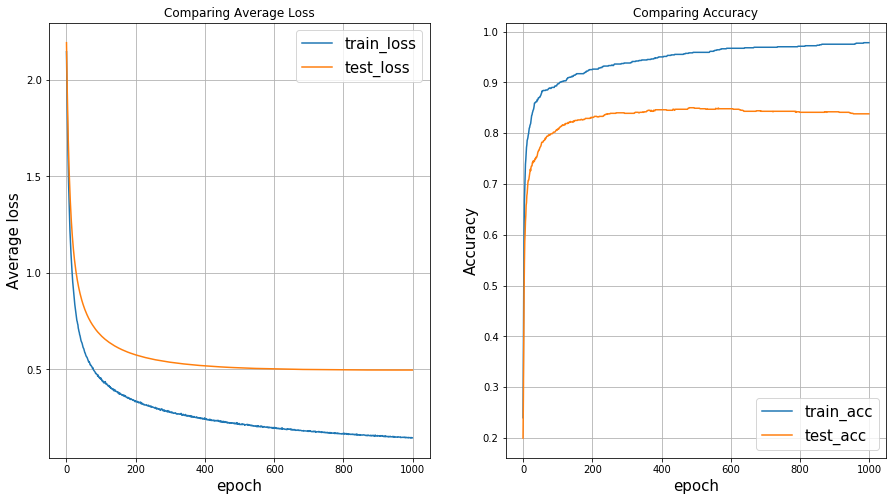

In [31]:
ploting_curves(train_seq_loss, test_seq_loss, train_seq_acc, test_seq_acc)

## ``gluon``正则化

我们先来看看在深度学习中为什么$l_2$正则化被称为$weight\_decay$，我们知道$l_2$正则化就是向损失函数加入罚项$\frac{\lambda}{2}\|\omega\|_2^2$，那么在梯度下降时就是对权重$\omega$的缩减就由$-\eta(g_t)$变成了$- \eta (g_t + \lambda \omega)$，我们可以看到，此时的权重和原来相比确实被缩减了，我们称为$weight\_decay$。

在``gluon``中加入$l_2$罚项十分简单

Epoch 100, MovingAvgTrain loss 0.455936736578, Train avg loss 0.455552197993,Test avg loss 0.675782036036,Train acc 0.896, Test acc 0.806
Epoch 200, MovingAvgTrain loss 0.334022248193, Train avg loss 0.335016037337,Test avg loss 0.574833255261,Train acc 0.925, Test acc 0.831
Epoch 300, MovingAvgTrain loss 0.282341435084, Train avg loss 0.276306700893,Test avg loss 0.536342695355,Train acc 0.938, Test acc 0.839
Epoch 400, MovingAvgTrain loss 0.244671408584, Train avg loss 0.247816063464,Test avg loss 0.517458047718,Train acc 0.95, Test acc 0.846
Epoch 500, MovingAvgTrain loss 0.230297799842, Train avg loss 0.218607029878,Test avg loss 0.507304791361,Train acc 0.959, Test acc 0.849
Epoch 600, MovingAvgTrain loss 0.200130589593, Train avg loss 0.19489408657,Test avg loss 0.501609034836,Train acc 0.967, Test acc 0.848
Epoch 700, MovingAvgTrain loss 0.18553188082, Train avg loss 0.178002641536,Test avg loss 0.498355109245,Train acc 0.969, Test acc 0.843
Epoch 800, MovingAvgTrain loss 0.1631

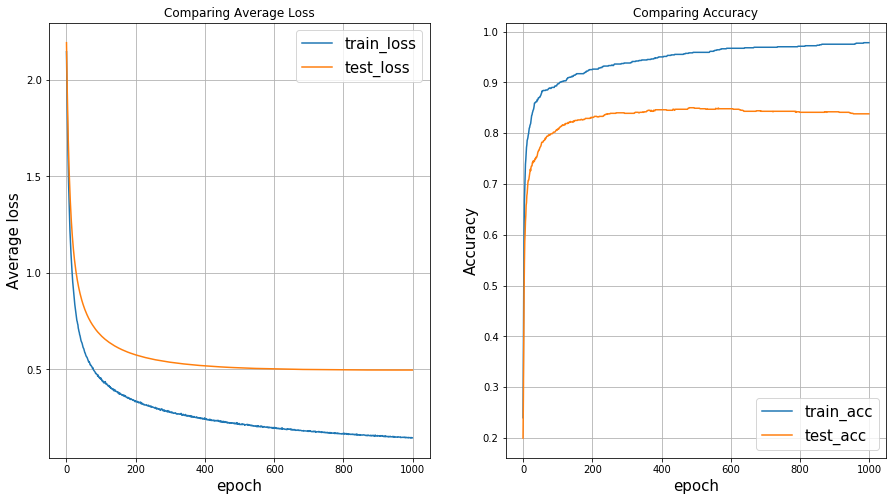

In [14]:
# 参数重新初始化
net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), force_reinit=True)
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': learning_rate, 'wd':0.001})

# 训练
epochs = 1000
learning_rate = 0.01

niter = 0
moving_loss = 0.0
smoothing_constant = 0.1

train_seq_loss = []
train_seq_acc = []
test_seq_loss = []
test_seq_acc = []

for epoch in range(epochs):
    cumulative_loss = .0
    for i, (data, label) in enumerate(train_data):
        data = data.reshape((-1, 784)) 
        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        trainer.step(batch_size)
        cumulative_loss += nd.sum(loss).asscalar()
        
        # moving average loss 
        niter += 1
        curr_loss = nd.mean(loss).asscalar()
        moving_loss = (1 - smoothing_constant) * moving_loss + smoothing_constant * curr_loss
        estimated_loss = moving_loss / (1 - (1-smoothing_constant)**niter)
        
    train_acc, train_avg_loss = evaluate_accuracy(train_data, net, softmax_cross_entropy)
    test_acc, test_avg_loss = evaluate_accuracy(test_data, net, softmax_cross_entropy)
    train_seq_loss.append(train_avg_loss)
    train_seq_acc.append(train_acc)
    test_seq_loss.append(test_avg_loss)
    test_seq_acc.append(test_acc)
    
    if not (epoch+1) % 100:
        print("Epoch %s, MovingAvgTrain loss %s, Train avg loss %s,Test avg loss %s,Train acc %s, Test acc %s" % (epoch+1, estimated_loss, train_avg_loss, test_avg_loss, train_acc, test_acc))

# 绘制曲线
ploting_curves(train_seq_loss, test_seq_loss, train_seq_acc, test_seq_acc)        